In [13]:
from imbens.datasets import fetch_datasets
from imbens.ensemble import *
from imbens.metrics import geometric_mean_score
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sympy.physics.quantum.gate import CPHASE
from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import  matplotlib.pyplot as plt
from catboost import CatBoostClassifier

if __name__ == '__main__':
    dataset_name = "spectrometer"
    dataset = fetch_datasets()[dataset_name]
    X, y = dataset['data'], dataset['target']
    y = np.where(y == -1, 0, y)
    print(len(X[0]))
    # 计算正负样本数
    positive_samples = sum(y)  # y 中值为 1 的样本
    negative_samples = len(y) - positive_samples  # 负样本数

    print(positive_samples)
    print(negative_samples)
    # 计算 IR（不平衡比率）
    IR = negative_samples / positive_samples if negative_samples != 0 else float('inf')  # 防止除以零

    # 输出 IR 值
    print(f"{IR:.1f}")

    skf = StratifiedKFold(n_splits=5, shuffle=True)

    f1_macro_list = []
    auc_list = []
    aupr_list = []
    gmean_list = []

    for train_idx, test_idx in skf.split(X, y):
        X_train_cv, X_val_cv = X[train_idx], X[test_idx]
        y_train_cv, y_val_cv = y[train_idx], y[test_idx]




        # 循环遍历训练集大小（从 2% 到 100%）
        for percent in range(10, 100, 4):
            train_size = percent / 100  # 当前训练集比例
            X_train_subset, _, y_train_subset, _ = train_test_split(X_train_cv, y_train_cv, train_size=train_size,
                                                                        stratify=y_train_cv)

            # 使用自适应集成模型
            # model = UncertaintyAwareDeepForest(get_config())
            model = AsymBoostClassifier()
            model.fit(X_train_subset, y_train_subset)  # 训练模型

            # 预测
            y_pred = model.predict(X_val_cv)
            y_pred_proba = model.predict_proba(X_val_cv)[:, 1]  # 获取预测的概率值，用于计算 AUC 和 AUPR

            # 计算性能指标
            f1_macro = f1_score(y_val_cv, y_pred, average='macro')
            auc = roc_auc_score(y_val_cv, y_pred_proba)
            aupr = average_precision_score(y_val_cv, y_pred_proba)
            gmean = geometric_mean_score(y_val_cv, y_pred)

            # 保存每轮的性能指标
            f1_macro_list.append(f1_macro)
            auc_list.append(auc)
            aupr_list.append(aupr)
            gmean_list.append(gmean)

            # 输出当前训练集比例和各项指标
            print(f"Training size: {percent}%")
            print(f"F1-macro: {f1_macro:.4f}")
            print(f"AUC: {auc:.4f}")
            print(f"AUPR: {aupr:.4f}")
            print(f"Gmean: {gmean:.4f}")
            print("-" * 40)

    n = len(range(10, 100, 4))
    f1_macro_list = np.array(f1_macro_list).reshape(-1, n)
    f1_macro_list = np.mean(f1_macro_list, axis=0)
    auc_list = np.array(auc_list).reshape(-1, n)
    auc_list = np.mean(auc_list, axis=0)
    aupr_list = np.array(aupr_list).reshape(-1, n)
    aupr_list = np.mean(aupr_list, axis=0)
    gmean_list = np.array(gmean_list).reshape(-1, n)
    gmean_list = np.mean(gmean_list, axis=0)
    print(f1_macro_list)
    # 确保性能列表的长度与训练集百分比范围匹配
    print(len(f1_macro_list))  # 确保这是 50

    # 绘制性能指标变化图
    plt.figure(figsize=(12, 8))

    # F1-macro 曲线
    plt.subplot(2, 2, 1)
    plt.plot(range(10, 100, 4), f1_macro_list, marker='o', label="F1-macro")
    plt.title('F1-macro vs Training Size')
    plt.xlabel('Training Size (%)')
    plt.ylabel('F1-macro')
    plt.grid(True)

    # AUC 曲线
    plt.subplot(2, 2, 2)
    plt.plot(range(10, 100, 4), auc_list, marker='o', label="AUC", color='orange')
    plt.title('AUC vs Training Size')
    plt.xlabel('Training Size (%)')
    plt.ylabel('AUC')
    plt.grid(True)

    # AUPR 曲线
    plt.subplot(2, 2, 3)
    plt.plot(range(10, 100, 4), aupr_list, marker='o', label="AUPR", color='green')
    plt.title('AUPR vs Training Size')
    plt.xlabel('Training Size (%)')
    plt.ylabel('AUPR')
    plt.grid(True)

    # Gmean 曲线
    plt.subplot(2, 2, 4)
    plt.plot(range(10, 100, 4), gmean_list, marker='o', label="Gmean", color='red')
    plt.title('Gmean vs Training Size')
    plt.xlabel('Training Size (%)')
    plt.ylabel('Gmean')
    plt.grid(True)

    # 显示图表
    plt.tight_layout()
    plt.show()

    # 保存性能数据到文件
    np.savetxt("spectrometer_performance_metrics_AsymBC.csv", np.array([f1_macro_list, auc_list, aupr_list, gmean_list]).T,
                   delimiter=',', header="F1-macro,AUC,AUPR,Gmean", comments='')

93
45
486
10.8
Training size: 10%
F1-macro: 0.8787
AUC: 0.9592
AUPR: 0.8291
Gmean: 0.8729
----------------------------------------
Training size: 14%
F1-macro: 0.6646
AUC: 0.9705
AUPR: 0.8014
Gmean: 0.4714
----------------------------------------
Training size: 18%
F1-macro: 0.7953
AUC: 0.9002
AUPR: 0.7059
Gmean: 0.6667
----------------------------------------
Training size: 22%
F1-macro: 0.8208
AUC: 0.9864
AUPR: 0.8886
Gmean: 0.7415
----------------------------------------
Training size: 26%
F1-macro: 0.7953
AUC: 0.9909
AUPR: 0.9390
Gmean: 0.6667
----------------------------------------
Training size: 30%
F1-macro: 0.8925
AUC: 0.9626
AUPR: 0.8842
Gmean: 0.8165
----------------------------------------
Training size: 34%
F1-macro: 0.8471
AUC: 0.9751
AUPR: 0.9011
Gmean: 0.7454
----------------------------------------
Training size: 38%
F1-macro: 0.9042
AUC: 0.9138
AUPR: 0.8204
Gmean: 0.8774
----------------------------------------
Training size: 42%
F1-macro: 0.7953
AUC: 0.9677
AUPR: 0.8

KeyboardInterrupt: 

93
45
486
10.8
Training size: 10%
F1-macro: 0.6150
AUC: 0.4977
AUPR: 0.4898
Gmean: 0.6245
----------------------------------------
Training size: 14%
F1-macro: 0.5840
AUC: 0.8696
AUPR: 0.4219
Gmean: 0.7143
----------------------------------------
Training size: 18%
F1-macro: 0.9711
AUC: 0.9955
AUPR: 0.9488
Gmean: 0.9949
----------------------------------------
Training size: 22%
F1-macro: 0.8415
AUC: 0.9960
AUPR: 0.9576
Gmean: 0.9636
----------------------------------------
Training size: 26%
F1-macro: 0.8782
AUC: 0.9949
AUPR: 0.9437
Gmean: 0.9742
----------------------------------------
Training size: 30%
F1-macro: 0.8787
AUC: 0.9898
AUPR: 0.9094
Gmean: 0.8729
----------------------------------------
Training size: 34%
F1-macro: 0.9134
AUC: 0.9915
AUPR: 0.9138
Gmean: 0.9331
----------------------------------------
Training size: 38%
F1-macro: 0.9711
AUC: 1.0000
AUPR: 1.0000
Gmean: 0.9949
----------------------------------------
Training size: 42%
F1-macro: 0.9711
AUC: 1.0000
AUPR: 1.0

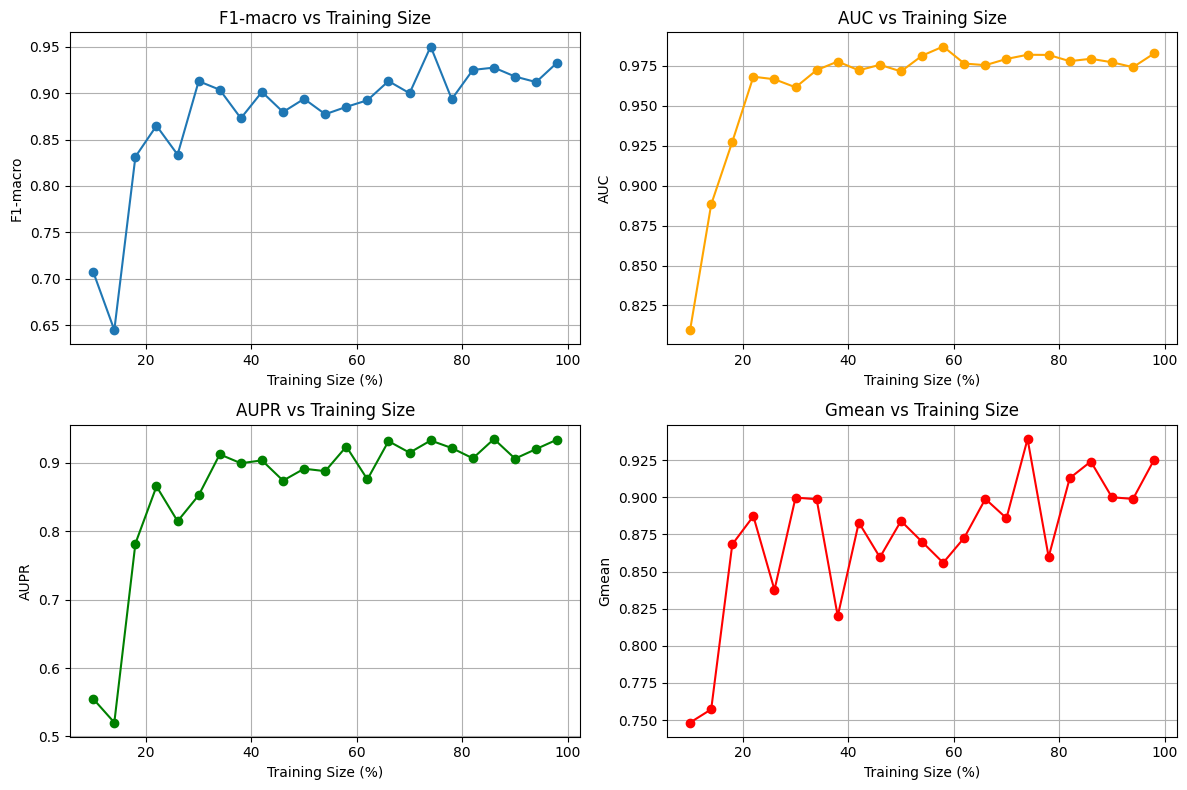

In [21]:
from imbens.datasets import fetch_datasets
from imbens.ensemble import *
from imbens.metrics import geometric_mean_score
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sympy.physics.quantum.gate import CPHASE
from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import  matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from data_util import *
from demo import get_config
from UADF import UncertaintyAwareDeepForest
if __name__ == '__main__':
    dataset_name = "spectrometer"
    dataset = fetch_datasets()[dataset_name]
    X, y = dataset['data'], dataset['target']
    y = np.where(y == -1, 0, y)
    # X, y, name = get_yeast5()

    print(len(X[0]))
    # 计算正负样本数
    positive_samples = sum(y)  # y 中值为 1 的样本
    negative_samples = len(y) - positive_samples  # 负样本数

    print(positive_samples)
    print(negative_samples)
    # 计算 IR（不平衡比率）
    IR = negative_samples / positive_samples if negative_samples != 0 else float('inf')  # 防止除以零

    # 输出 IR 值
    print(f"{IR:.1f}")

    skf = StratifiedKFold(n_splits=5, shuffle=True)

    f1_macro_list = []
    auc_list = []
    aupr_list = []
    gmean_list = []

    for train_idx, test_idx in skf.split(X, y):
        X_train_cv, X_val_cv = X[train_idx], X[test_idx]
        y_train_cv, y_val_cv = y[train_idx], y[test_idx]




        # 循环遍历训练集大小（从 2% 到 100%）
        for percent in range(10, 100, 4):
            train_size = percent / 100  # 当前训练集比例
            X_train_subset, _, y_train_subset, _ = train_test_split(X_train_cv, y_train_cv, train_size=train_size,stratify=y_train_cv)

            # 使用自适应集成模型
            # model = UncertaintyAwareDeepForest(get_config())
            model = SelfPacedEnsembleClassifier()
            model.fit(X_train_subset, y_train_subset)  # 训练模型

            # 预测
            y_pred = model.predict(X_val_cv)
            y_pred_proba = model.predict_proba(X_val_cv)[:, 1]  # 获取预测的概率值，用于计算 AUC 和 AUPR

            # 计算性能指标
            f1_macro = f1_score(y_val_cv, y_pred, average='macro')
            auc = roc_auc_score(y_val_cv, y_pred_proba)
            aupr = average_precision_score(y_val_cv, y_pred_proba)
            gmean = geometric_mean_score(y_val_cv, y_pred)

            # 保存每轮的性能指标
            f1_macro_list.append(f1_macro)
            auc_list.append(auc)
            aupr_list.append(aupr)
            gmean_list.append(gmean)

            # 输出当前训练集比例和各项指标
            print(f"Training size: {percent}%")
            print(f"F1-macro: {f1_macro:.4f}")
            print(f"AUC: {auc:.4f}")
            print(f"AUPR: {aupr:.4f}")
            print(f"Gmean: {gmean:.4f}")
            print("-" * 40)

    n = len(range(10, 100, 4))
    f1_macro_list = np.array(f1_macro_list).reshape(-1, n)
    f1_macro_list = np.mean(f1_macro_list, axis=0)
    auc_list = np.array(auc_list).reshape(-1, n)
    auc_list = np.mean(auc_list, axis=0)
    aupr_list = np.array(aupr_list).reshape(-1, n)
    aupr_list = np.mean(aupr_list, axis=0)
    gmean_list = np.array(gmean_list).reshape(-1, n)
    gmean_list = np.mean(gmean_list, axis=0)
    print(f1_macro_list)
    # 确保性能列表的长度与训练集百分比范围匹配
    print(len(f1_macro_list))  # 确保这是 50

    # 绘制性能指标变化图
    plt.figure(figsize=(12, 8))

    # F1-macro 曲线
    plt.subplot(2, 2, 1)
    plt.plot(range(10, 100, 4), f1_macro_list, marker='o', label="F1-macro")
    plt.title('F1-macro vs Training Size')
    plt.xlabel('Training Size (%)')
    plt.ylabel('F1-macro')
    plt.grid(True)

    # AUC 曲线
    plt.subplot(2, 2, 2)
    plt.plot(range(10, 100, 4), auc_list, marker='o', label="AUC", color='orange')
    plt.title('AUC vs Training Size')
    plt.xlabel('Training Size (%)')
    plt.ylabel('AUC')
    plt.grid(True)

    # AUPR 曲线
    plt.subplot(2, 2, 3)
    plt.plot(range(10, 100, 4), aupr_list, marker='o', label="AUPR", color='green')
    plt.title('AUPR vs Training Size')
    plt.xlabel('Training Size (%)')
    plt.ylabel('AUPR')
    plt.grid(True)

    # Gmean 曲线
    plt.subplot(2, 2, 4)
    plt.plot(range(10, 100, 4), gmean_list, marker='o', label="Gmean", color='red')
    plt.title('Gmean vs Training Size')
    plt.xlabel('Training Size (%)')
    plt.ylabel('Gmean')
    plt.grid(True)

    # 显示图表
    plt.tight_layout()
    plt.show()

    # 保存性能数据到文件
    np.savetxt("spectrometer_performance_metrics_SPE.csv", np.array([f1_macro_list, auc_list, aupr_list, gmean_list]).T,
                   delimiter=',', header="F1-macro,AUC,AUPR,Gmean", comments='')